In [2]:
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# P5.2

In [2]:
def er_clustering(N, p, trials=100):
    vals = []
    for _ in range(trials):
        G = nx.erdos_renyi_graph(N, p)
        vals.append(nx.average_clustering(G))
    return np.mean(vals)

In [3]:
for p in [0.05, 0.1, 0.2, 0.4]:
    est = er_clustering(500, p)
    print(p, est)

0.05 0.050159665733349124
0.1 0.10006533550856066
0.2 0.20012607948914546
0.4 0.39998342127672126


# P5.3

In [9]:
def generate_sbm(p_in=0.3, p_out=0.01):
    assert p_in > p_out
    sizes = [20, 20, 20, 20]

    P = np.full((4, 4), p_out)
    np.fill_diagonal(P, p_in)

    G = nx.stochastic_block_model(sizes, P)
    return G


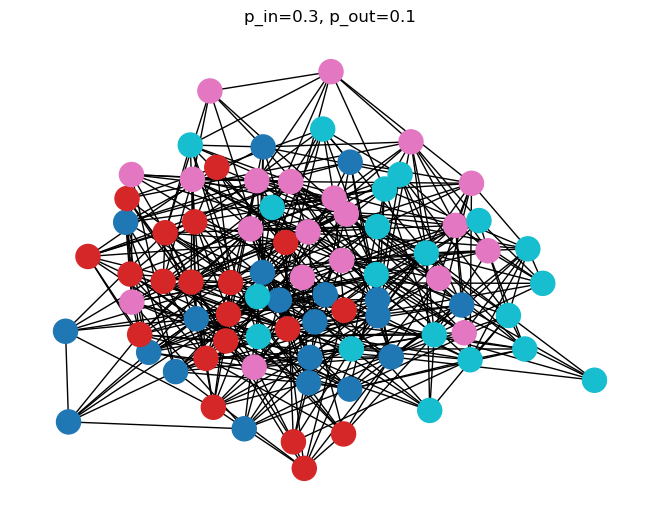

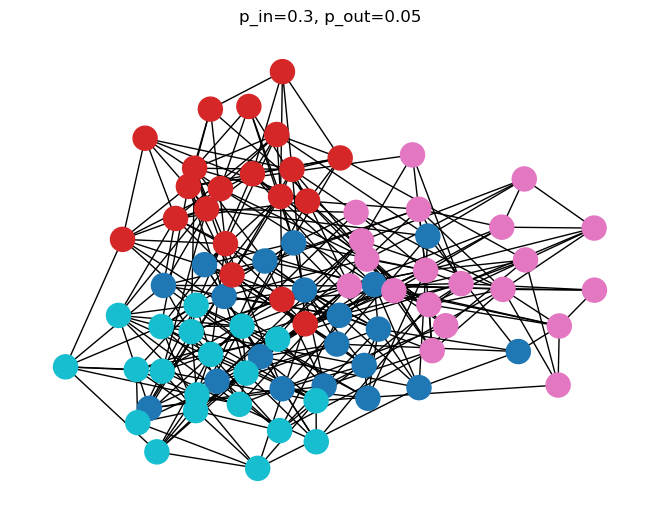

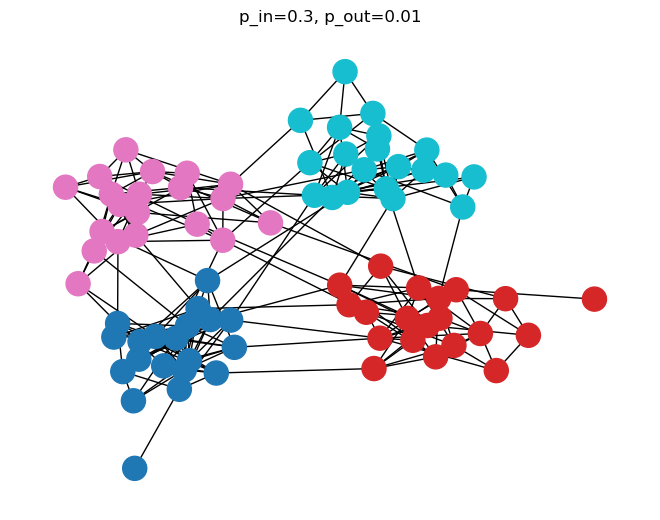

In [11]:
for p_out in [0.1, 0.05, 0.01]:
    G = generate_sbm(p_out=p_out)
    pos = nx.spring_layout(G)

    colors = []
    for i, block in enumerate([20, 20, 20, 20]):
        colors += [i] * block

    nx.draw(G, pos, node_color=colors, cmap="tab10")
    plt.title(f"p_in={0.3}, p_out={p_out}")
    plt.show()

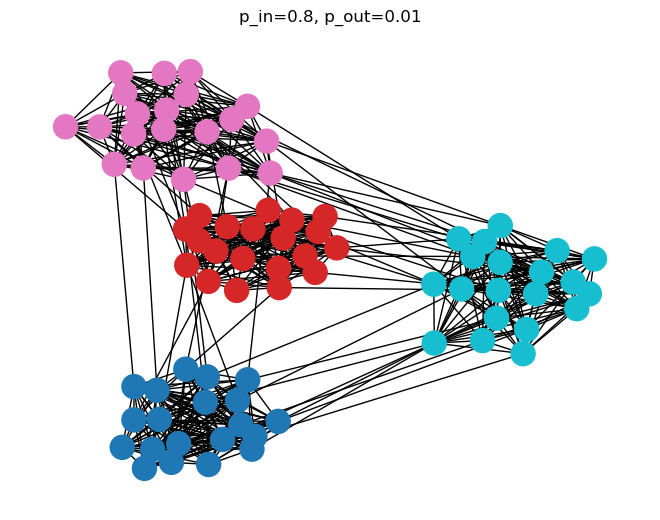

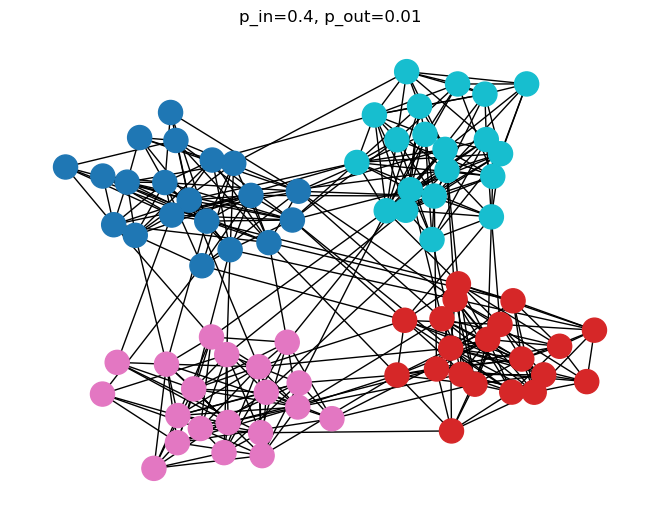

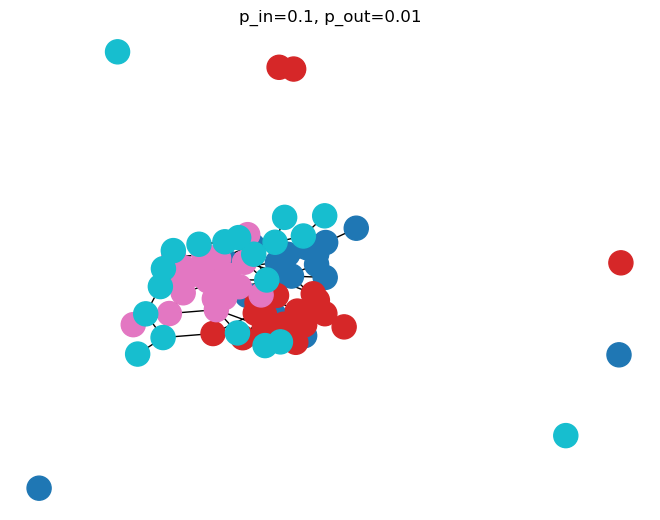

In [14]:
for p_in in [0.8, 0.4, 0.1]:
    G = generate_sbm(p_in=p_in)
    pos = nx.spring_layout(G)

    colors = []
    for i, block in enumerate([20, 20, 20, 20]):
        colors += [i] * block

    nx.draw(G, pos, node_color=colors, cmap="tab10")
    plt.title(f"p_in={p_in}, p_out={0.01}")
    plt.show()

# P5.4

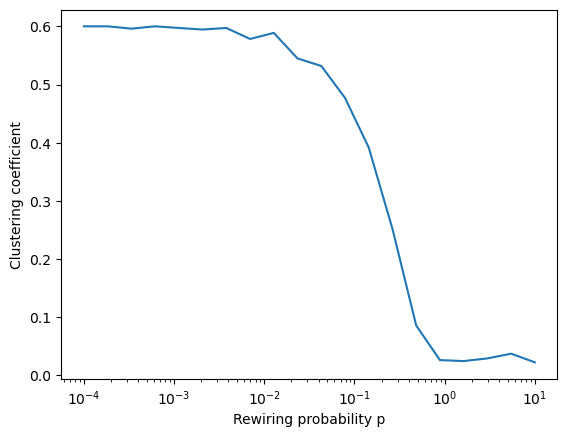

In [18]:
N = 200
k = 6
ps = np.logspace(-4, 1, 20)  #p=1 -> random graph
c_vals = []

for p in ps:
    G = nx.watts_strogatz_graph(N, k, p)
    c_vals.append(nx.average_clustering(G))

plt.semilogx(ps, c_vals)
plt.xlabel("Rewiring probability p")
plt.ylabel("Clustering coefficient")
plt.show()

# P5.6

In [45]:
def configuration_model_simple(degseq, max_attempts=10000):
    """
    Attempts to generate a simple graph (no self-loops, no multiedges)
    having the given degree sequence using the configuration model.

    Parameters:
        degseq       : list of degrees
        max_attempts : maximum number of random pairings to try

    Returns:
        G(nx.Graph) : if successful or None if the procedure does not converge
        attempt     : attempt number of success, zero if not successful
    """
    n = len(degseq)

    # Check degree sequence validity (sum even + graphical)
    if sum(degseq) % 2 != 0:
        raise ValueError("Degree sum must be even.")
    if not nx.is_graphical(degseq, method="eg"):
        raise ValueError("Degree sequence is not graphical.")

    # Create stubs (node repeated deg[node] times)
    stubs = []
    for node, d in enumerate(degseq):
        stubs.extend([node] * d)

    # Try random pairings
    for attempt in range(max_attempts):
        random.shuffle(stubs)
        edges = []
        simple = True
        seen = set()

        # create edges
        for i in range(0, len(stubs), 2):
            u, v = stubs[i], stubs[i + 1]

            # reject self-loops
            if u == v:
                simple = False
                break

            # order edge
            a, b = (u, v) if u < v else (v, u)

            # reject multiple edges
            if (a, b) in seen:
                simple = False
                break

            seen.add((a, b))
            edges.append((a, b))

        if simple:
            G = nx.Graph()
            G.add_nodes_from(range(n))
            G.add_edges_from(edges)
            return G, attempt  # success

    return None, 0  # did not converge


def test_convergence(degseq, trials=10):
    """
    Try several times to generate a simple graph from a degree sequence.
    Returns success rate.
    """
    success = 0
    avg_attempt = 0
    for _ in range(trials):
        try:
            G, attempt = configuration_model_simple(degseq, max_attempts=2000)
        except ValueError as e:
            #print(e)
            continue
        if G is not None:
            success += 1
            avg_attempt += 1
    return success / trials, 0 if success == 0 else avg_attempt / success

In [46]:
def power_law_degseq(n, gamma=2.2, kmax=49):
    ks = np.arange(1, kmax + 1)
    p = ks ** (-gamma)
    p = p / p.sum()
    seq = list(np.random.choice(ks, size=n, p=p))
    if sum(seq) % 2 == 1:
        seq[0] += 1
    return seq


def poisson_degseq(n, avg_deg=4):
    degseq_poisson = list(np.random.poisson(avg_deg, size=n))
    # ensure even sum:
    if sum(degseq_poisson) % 2 == 1:
        degseq_poisson[0] += 1
    return degseq_poisson


def regular_degseq(n, avg_deg=4):
    return [avg_deg] * n

In [47]:
def run_convergence_test(method, method_name, param=4, size=50):
    print(f"{'gamma' if method_name == "power_law" else "avg_deg"}={param}, size={size}")

    s_rate = 0
    att_nr = 0
    for _ in range(10):
        degseq = method(size, param)
        result = test_convergence(degseq)
        s_rate += result[0]
        att_nr += result[1]
    print(f"{method_name}:", (s_rate / 10, att_nr / 10))

    print("Test completed.\n")
    return s_rate / 10, att_nr / 10

In [48]:
print("=== Configuration Model Convergence Tests ===")
print("How generated sequence: (success rate, average attempt nr for success)")
run_convergence_test(regular_degseq, "regular")
run_convergence_test(poisson_degseq, "poisson")
run_convergence_test(power_law_degseq, "power_law", param=2.2)
print("")

=== Configuration Model Convergence Tests ===
How generated sequence: (success rate, average attempt nr for success)
avg_deg=4, size=50
regular: (1.0, 1.0)
Test completed.

avg_deg=4, size=50
poisson: (0.9700000000000001, 1.0)
Test completed.

gamma=2.2, size=50
power_law: (0.72, 0.8)
Test completed.




In [49]:
def run_convergence_test_and_plot(method, method_name, params=None, sizes=None):
    if sizes is None:
        sizes = [50]
    if params is None:
        params = [4]

    results = []
    param_name = 'Gamma' if method_name == "power_law" else "Average degree"

    for size in sizes:
        for param in params:
            success_rate, avg_attempts = run_convergence_test(method, method_name, param=param, size=size)
            results.append({
                'size': size,
                param_name: param,
                'success_rate': success_rate,
                'avg_attempts': avg_attempts
            })

    df = pd.DataFrame(results)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(8, 5))

    for size in df['size'].unique():
        subset = df[df['size'] == size]
        ax1.plot(subset[param_name], subset['success_rate'], marker='o', label=f'Success Rate (size={size})')

    ax1.set_xlabel(param_name)
    ax1.set_ylabel('Success Rate')
    ax1.set_title(f'Convergence Test: Success Rate vs {param_name}')
    ax1.legend()
    ax1.grid(True)
    plt.tight_layout()
    plt.show()

    return

=== Configuration Model Convergence Tests ===
How generated sequence: (success rate, average attempt nr for success)
avg_deg=4, size=20
regular: (1.0, 1.0)
Test completed.

avg_deg=5, size=20
regular: (0.9400000000000001, 1.0)
Test completed.

avg_deg=6, size=20
regular: (0.10999999999999999, 0.8)
Test completed.

avg_deg=7, size=20
regular: (0.0, 0.0)
Test completed.

avg_deg=4, size=40
regular: (1.0, 1.0)
Test completed.

avg_deg=5, size=40
regular: (0.95, 1.0)
Test completed.

avg_deg=6, size=40
regular: (0.32, 0.9)
Test completed.

avg_deg=7, size=40
regular: (0.0, 0.0)
Test completed.

avg_deg=4, size=60
regular: (1.0, 1.0)
Test completed.

avg_deg=5, size=60
regular: (0.99, 1.0)
Test completed.

avg_deg=6, size=60
regular: (0.2, 0.9)
Test completed.

avg_deg=7, size=60
regular: (0.0, 0.0)
Test completed.

avg_deg=4, size=80
regular: (1.0, 1.0)
Test completed.

avg_deg=5, size=80
regular: (1.0, 1.0)
Test completed.

avg_deg=6, size=80
regular: (0.16999999999999998, 0.9)
Test compl

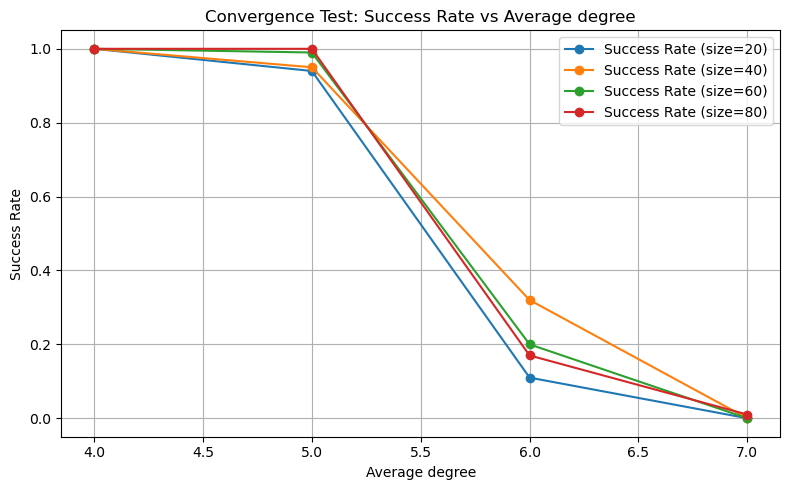

In [51]:
print("=== Configuration Model Convergence Tests ===")
print("How generated sequence: (success rate, average attempt nr for success)")
run_convergence_test_and_plot(regular_degseq, "regular", params=range(4, 8), sizes=range(20, 100, 20))

=== Configuration Model Convergence Tests ===
How generated sequence: (success rate, average attempt nr for success)
avg_deg=4, size=20
poisson: (0.8399999999999999, 1.0)
Test completed.

avg_deg=5, size=20
poisson: (0.18000000000000002, 0.7)
Test completed.

avg_deg=6, size=20
poisson: (0.01, 0.1)
Test completed.

avg_deg=7, size=20
poisson: (0.0, 0.0)
Test completed.

avg_deg=4, size=40
poisson: (0.7300000000000001, 0.9)
Test completed.

avg_deg=5, size=40
poisson: (0.23000000000000004, 0.7)
Test completed.

avg_deg=6, size=40
poisson: (0.02, 0.2)
Test completed.

avg_deg=7, size=40
poisson: (0.0, 0.0)
Test completed.

avg_deg=4, size=60
poisson: (0.9199999999999999, 1.0)
Test completed.

avg_deg=5, size=60
poisson: (0.16999999999999998, 0.7)
Test completed.

avg_deg=6, size=60
poisson: (0.0, 0.0)
Test completed.

avg_deg=7, size=60
poisson: (0.0, 0.0)
Test completed.

avg_deg=4, size=80
poisson: (0.9, 1.0)
Test completed.

avg_deg=5, size=80
poisson: (0.22000000000000006, 0.9)
Test 

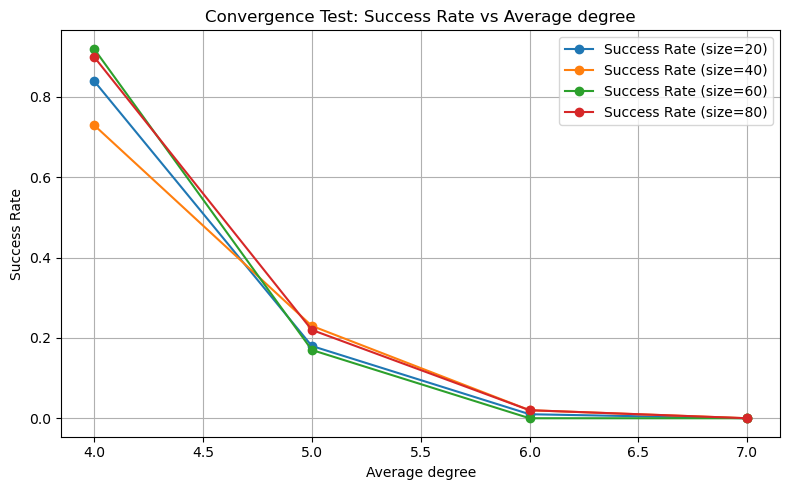

In [53]:
print("=== Configuration Model Convergence Tests ===")
print("How generated sequence: (success rate, average attempt nr for success)")
run_convergence_test_and_plot(poisson_degseq, "poisson", params=range(4, 8), sizes=range(20, 100, 20))

=== Configuration Model Convergence Tests ===
How generated sequence: (success rate, average attempt nr for success)
gamma=1.8, size=20
power_law: (0.12, 0.2)
Test completed.

gamma=2.0, size=20
power_law: (0.3, 0.3)
Test completed.

gamma=2.2, size=20
power_law: (0.63, 0.7)
Test completed.

gamma=2.4, size=20
power_law: (0.89, 0.9)
Test completed.

gamma=2.5999999999999996, size=20
power_law: (0.9099999999999999, 1.0)
Test completed.

gamma=2.8, size=20
power_law: (1.0, 1.0)
Test completed.

gamma=3.0, size=20
power_law: (1.0, 1.0)
Test completed.

gamma=1.8, size=40
power_law: (0.0, 0.0)
Test completed.

gamma=2.0, size=40
power_law: (0.13999999999999999, 0.2)
Test completed.

gamma=2.2, size=40
power_law: (0.5, 0.5)
Test completed.

gamma=2.4, size=40
power_law: (0.58, 0.7)
Test completed.

gamma=2.5999999999999996, size=40
power_law: (0.9800000000000001, 1.0)
Test completed.

gamma=2.8, size=40
power_law: (0.97, 1.0)
Test completed.

gamma=3.0, size=40
power_law: (1.0, 1.0)
Test co

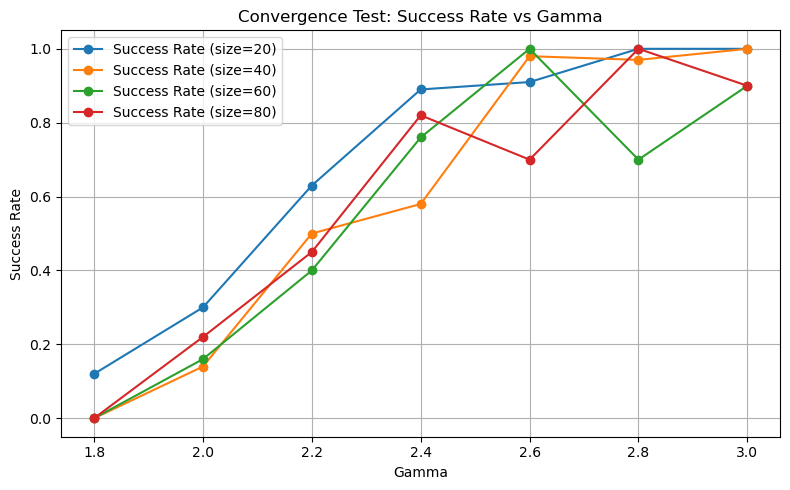

In [55]:
print("=== Configuration Model Convergence Tests ===")
print("How generated sequence: (success rate, average attempt nr for success)")
run_convergence_test_and_plot(power_law_degseq, "power_law", params=np.arange(1.8, 3.01, 0.2), sizes=range(20, 100, 20))